In [29]:
import pandas as pd

umi_counts = pd.read_csv("../data/scHiC/GSE148793_UMI_counts.txt", sep="\t")
ab_data = pd.read_csv("../data/scHiC/GSE148793_genomic_bin_a_score_per_cell.txt", sep="\t")

In [30]:
umi_counts.head()

,ME0/ABEC0021.WEC0010004,ME0/ABEC0021.WEC0010005,ME0/ABEC0021.WEC0010006,ME0/ABEC0021.WEC0010007,ME0/ABEC0021.WEC0010008,ME0/ABEC0021.WEC0010010,ME0/ABEC0021.WEC0010011,ME0/ABEC0021.WEC0010012,ME0/ABEC0021.WEC0010013,ME0/ABEC0021.WEC0010014,...,ME1/ABEC0054.WEC0026342,ME1/ABEC0054.WEC0026345,ME1/ABEC0054.WEC0026346,ME1/ABEC0054.WEC0026347,ME1/ABEC0054.WEC0026348,ME1/ABEC0054.WEC0026349,ME1/ABEC0054.WEC0026350,ME1/ABEC0054.WEC0026355,ME1/ABEC0054.WEC0026357,ME1/ABEC0054.WEC0026358
0610007C21Rik;Apr3,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610007L01Rik,0,0,0,2,0,1,2,1,0,1,...,0,2,0,0,1,0,2,0,1,0
0610007P08Rik;Rad26l,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610007P14Rik,0,0,1,1,0,0,0,2,0,2,...,0,0,0,2,1,0,0,0,0,1
0610007P22Rik,0,0,0,0,0,0,0,0,0,1,...,0,1,0,1,0,0,0,2,0,0


In [31]:
ab_data.head()

,f1,cell,b,a
1,chr1_100000001,elad.schic.e95.E9B_p10_10E,1,0
2,chr1_100000001,elad.schic.e95.E9B_p10_10H,1,0
3,chr1_100000001,elad.schic.e95.E9B_p10_10J,0,1
4,chr1_100000001,elad.schic.e95.E9B_p10_10K,1,0
5,chr1_100000001,elad.schic.e95.E9B_p10_10M,0,2


In [32]:
# Process the Hi-C data
ab_data['a_score'] = ab_data['a'] / (ab_data['a'] + ab_data['b'])

# Replace NaN values with 0
ab_data['a_score'] = ab_data['a_score'].fillna(0)

# Create the pivot table for Hi-C data (bins × cells)
hic_matrix = ab_data.pivot(index='f1', columns='cell', values='a_score').fillna(0)

In [33]:
# Save the processed Hi-C matrix
hic_matrix.to_csv("../data/scHiC/processed_hic_matrix.csv")

# Save the UMI matrix
umi_counts.to_csv("../data/scHiC/processed_umi_matrix.csv")

In [35]:
import pandas as pd

hic_matrix = pd.read_csv("../data/scHiC/processed_hic_matrix.csv")
umi_counts = pd.read_csv("../data/scHiC/processed_umi_matrix.csv")

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
from scipy.spatial import procrustes
from scipy.stats import pearsonr, spearmanr
import warnings

def preprocess_and_align_datasets(rna_df, hic_df, dim_reduction='pca', 
                                  n_components=None, explained_variance=0.8):
    """
    Preprocess and align RNA-seq and Hi-C datasets to create matched samples.
    This function subsamples the larger dataset to match the smaller one.
    
    Parameters:
    -----------
    rna_df : DataFrame
        RNA-seq data with features in rows, samples in columns.
    hic_df : DataFrame
        Hi-C data with features in rows, samples in columns.
    dim_reduction : str, optional
        Dimensionality reduction method ('pca' [default] or 'umap')
    n_components : int, optional
        Number of components for dimensionality reduction.
        If None, will be determined by explained_variance.
    explained_variance : float, optional
        Minimum explained variance threshold for PCA (default: 0.8)
        
    Returns:
    --------
    DataFrame
        Processed RNA-seq data with matched samples
    DataFrame
        Processed Hi-C data with matched samples
    dict
        Mapping information and alignment metrics
    """
    # Input validation
    if not isinstance(rna_df, pd.DataFrame) or not isinstance(hic_df, pd.DataFrame):
        raise TypeError("Input datasets must be pandas DataFrames")
    
    # Check for missing values
    if rna_df.isnull().values.any():
        warnings.warn("RNA-seq dataset contains missing values. Handling with mean imputation.")
        rna_df = rna_df.fillna(rna_df.mean())
    
    if hic_df.isnull().values.any():
        warnings.warn("Hi-C dataset contains missing values. Handling with mean imputation.")
        hic_df = hic_df.fillna(hic_df.mean())
        
    # Step 1: Extract feature names and convert to numpy arrays
    rna_features = rna_df.iloc[:, 0].values
    hic_features = hic_df.iloc[:, 0].values
    
    # Convert data to numpy arrays (exclude feature names column)
    rna_data_raw = rna_df.iloc[:, 1:].values
    hic_data_raw = hic_df.iloc[:, 1:].values
    
    # Remove constant features (no variation across samples)
    rna_std = np.std(rna_data_raw, axis=1)
    hic_std = np.std(hic_data_raw, axis=1)
    
    # Keep features with variation
    rna_variable_idx = np.where(rna_std > 0)[0]
    hic_variable_idx = np.where(hic_std > 0)[0]
    
    # Filter features and features names
    rna_features = rna_features[rna_variable_idx]
    hic_features = hic_features[hic_variable_idx]
    rna_data_filtered = rna_data_raw[rna_variable_idx, :]
    hic_data_filtered = hic_data_raw[hic_variable_idx, :]
    
    # Transpose to get samples in rows
    rna_data = rna_data_filtered.T
    hic_data = hic_data_filtered.T
    
    print(f"Removed {len(rna_std) - len(rna_variable_idx)} constant features from RNA data")
    print(f"Removed {len(hic_std) - len(hic_variable_idx)} constant features from Hi-C data")
    
    # Get sample names
    rna_samples = rna_df.columns[1:].tolist()
    hic_samples = hic_df.columns[1:].tolist()
    
    print(f"RNA dataset: {rna_data.shape[0]} samples x {rna_data.shape[1]} features")
    print(f"Hi-C dataset: {hic_data.shape[0]} samples x {hic_data.shape[1]} features")
    
    # Determine which dataset is smaller
    if rna_data.shape[0] <= hic_data.shape[0]:
        smaller_dataset = "rna"
        smaller_samples = rna_samples
        smaller_data = rna_data
        larger_dataset = "hic"
        larger_samples = hic_samples
        larger_data = hic_data
    else:
        smaller_dataset = "hic"
        smaller_samples = hic_samples
        smaller_data = hic_data
        larger_dataset = "rna"
        larger_samples = rna_samples
        larger_data = rna_data
    
    print(f"Smaller dataset: {smaller_dataset} with {smaller_data.shape[0]} samples")
    print(f"Larger dataset: {larger_dataset} with {larger_data.shape[0]} samples")
    
    # Step 2: Scale datasets separately
    smaller_scaler = StandardScaler()
    smaller_scaled = smaller_scaler.fit_transform(smaller_data)
    
    larger_scaler = StandardScaler()
    larger_scaled = larger_scaler.fit_transform(larger_data)
    
    # Step 3: Dimensionality reduction
    if dim_reduction.lower() == 'pca':
        # Determine number of components
        if n_components is None:
            # Find number of components needed to explain desired variance
            temp_pca = PCA()
            temp_pca.fit(smaller_scaled)
            cumulative_variance = np.cumsum(temp_pca.explained_variance_ratio_)
            n_components = np.argmax(cumulative_variance >= explained_variance) + 1
            n_components = min(n_components, min(smaller_scaled.shape[0], smaller_scaled.shape[1]))
            print(f"Selected {n_components} components to explain {explained_variance:.1%} of variance")
        
        # Apply PCA to smaller dataset
        smaller_red = PCA(n_components=n_components)
        smaller_red_data = smaller_red.fit_transform(smaller_scaled)
        print(f"Explained variance (smaller): {sum(smaller_red.explained_variance_ratio_):.1%}")
        
        # Apply PCA to larger dataset
        larger_red = PCA(n_components=n_components)
        larger_red_data = larger_red.fit_transform(larger_scaled)
        print(f"Explained variance (larger): {sum(larger_red.explained_variance_ratio_):.1%}")
        
    elif dim_reduction.lower() == 'umap':
        # UMAP for potentially non-linear relationships
        n_components = 2 if n_components is None else min(n_components, 10)
        
        # Apply UMAP to smaller dataset
        smaller_red = UMAP(n_components=n_components, random_state=42)
        smaller_red_data = smaller_red.fit_transform(smaller_scaled)
        
        # Apply UMAP to larger dataset
        larger_red = UMAP(n_components=n_components, random_state=42)
        larger_red_data = larger_red.fit_transform(larger_scaled)
        
        print(f"Applied UMAP with {n_components} components")
    else:
        raise ValueError(f"Unknown dimensionality reduction method: {dim_reduction}")
    
    # Step 4: Subsample the larger dataset to match the smaller one
    # Find the best subset of samples in the larger dataset that most closely matches the smaller dataset
    
    # Compute initial alignment to determine best samples
    mtx1, mtx2, initial_disparity = procrustes(
        smaller_red_data, 
        larger_red_data[:smaller_red_data.shape[0]]
    )
    print(f"Initial alignment disparity: {initial_disparity:.4f} (lower is better)")
    
    # Find optimal subset using greedy approach
    best_indices = select_best_matching_samples(
        larger_red_data, 
        smaller_red_data,
        n_samples=smaller_red_data.shape[0]
    )
    
    # Subset the larger dataset
    subsampled_larger_data = larger_data[best_indices]
    subsampled_larger_scaled = larger_scaled[best_indices]
    subsampled_larger_red_data = larger_red_data[best_indices]
    subsampled_larger_samples = [larger_samples[i] for i in best_indices]
    
    # Final alignment check with selected samples
    mtx1, mtx2, final_disparity = procrustes(smaller_red_data, subsampled_larger_red_data)
    print(f"Final alignment disparity: {final_disparity:.4f}")
    
    # Evaluation metrics
    # Compute correlation between feature spaces
    feature_corr = compute_feature_correlations(
        smaller_scaled, subsampled_larger_scaled, 
        n_pairs=min(100, smaller_scaled.shape[1])
    )
    print(f"Average feature correlation: {np.mean(feature_corr):.4f}")
    
    # Prepare final datasets
    final_smaller_data = smaller_data
    final_larger_data = subsampled_larger_data
    final_sample_names = smaller_samples
    final_mapping = {
        smaller_samples[i]: subsampled_larger_samples[i] 
        for i in range(len(smaller_samples))
    }
    
    # Convert back to dataframes with the original structure
    if smaller_dataset == "rna":
        # RNA was the smaller dataset
        final_rna_data = final_smaller_data
        final_hic_data = final_larger_data
        
        final_rna_df = pd.DataFrame(final_rna_data.T, columns=final_sample_names)
        final_hic_df = pd.DataFrame(final_larger_data.T, columns=final_sample_names)
        
        final_rna_df.insert(0, 'Feature', rna_features)
        final_hic_df.insert(0, 'Feature', hic_features)
    else:
        # Hi-C was the smaller dataset
        final_rna_data = final_larger_data
        final_hic_data = final_smaller_data
        
        final_rna_df = pd.DataFrame(final_rna_data.T, columns=final_sample_names)
        final_hic_df = pd.DataFrame(final_hic_data.T, columns=final_sample_names)
        
        final_rna_df.insert(0, 'Feature', rna_features)
        final_hic_df.insert(0, 'Feature', hic_features)
    
    return final_rna_df, final_hic_df, {
        'disparity': final_disparity,
        'original_samples': {
            'rna': rna_samples,
            'hic': hic_samples
        },
        'final_samples': final_sample_names,
        'alignment_info': {
            'method': 'subsample',
            'dim_reduction': dim_reduction,
            'n_components': n_components,
            'smaller_dataset': smaller_dataset,
            'sample_mapping': final_mapping
        },
        'evaluation': {
            'feature_correlation': np.mean(feature_corr) if 'feature_corr' in locals() else None
        }
    }

def select_best_matching_samples(larger_data, smaller_data, n_samples, method='greedy'):
    """
    Select the subset of samples from the larger dataset that best aligns
    with the smaller dataset.
    
    Parameters:
    -----------
    larger_data : array-like
        Data from the larger dataset (in reduced dimensionality)
    smaller_data : array-like
        Data from the smaller dataset (in reduced dimensionality)
    n_samples : int
        Number of samples to select
    method : str
        Selection method ('greedy' or 'random')
        
    Returns:
    --------
    array-like
        Indices of selected samples from the larger dataset
    """
    if method == 'random':
        # Simple random selection (baseline)
        return np.random.choice(
            larger_data.shape[0], size=n_samples, replace=False
        )
    
    elif method == 'greedy':
        # Greedy selection to minimize distance
        from scipy.spatial.distance import cdist
        
        # Compute pairwise distances between all samples
        distances = cdist(smaller_data, larger_data)
        
        selected_indices = []
        remaining_indices = list(range(larger_data.shape[0]))
        smaller_indices = list(range(smaller_data.shape[0]))
        
        for i in range(min(n_samples, smaller_data.shape[0])):
            # Find best match for current smaller dataset sample
            smaller_idx = smaller_indices[i]
            
            # Get distances to current sample
            sample_distances = distances[smaller_idx, remaining_indices]
            
            # Find closest remaining sample
            closest_idx = np.argmin(sample_distances)
            best_idx = remaining_indices[closest_idx]
            
            # Add to selected and remove from remaining
            selected_indices.append(best_idx)
            remaining_indices.remove(best_idx)
            
        # If we need more samples than in the smaller dataset,
        # add random samples from the remaining indices
        if n_samples > len(selected_indices):
            additional = np.random.choice(
                remaining_indices, 
                size=n_samples - len(selected_indices), 
                replace=False
            )
            selected_indices.extend(additional)
        
        return np.array(selected_indices)
    
    else:
        raise ValueError(f"Unknown selection method: {method}")

def compute_feature_correlations(data1, data2, n_pairs=100):
    """
    Compute correlations between random pairs of features
    across the two datasets.
    
    Parameters:
    -----------
    data1 : array-like
        First dataset (samples x features)
    data2 : array-like
        Second dataset (samples x features)
    n_pairs : int
        Number of random feature pairs to evaluate
        
    Returns:
    --------
    array-like
        Correlation values for each pair
    """
    # Make sure datasets have the same number of samples
    assert data1.shape[0] == data2.shape[0], "Datasets must have same number of samples"
    
    n_features1 = data1.shape[1]
    n_features2 = data2.shape[1]
    
    # Number of pairs to evaluate
    n_pairs = min(n_pairs, min(n_features1, n_features2))
    
    # Select random features
    features1 = np.random.choice(n_features1, size=n_pairs, replace=False)
    features2 = np.random.choice(n_features2, size=n_pairs, replace=False)
    
    correlations = []
    for i in range(n_pairs):
        f1 = features1[i]
        f2 = features2[i]
        
        # Get feature values
        values1 = data1[:, f1]
        values2 = data2[:, f2]
        
        # Compute correlation
        corr, _ = spearmanr(values1, values2)
        correlations.append(corr)
    
    return np.array(correlations)

In [37]:
# Align datasets to create matching samples
aligned_rna, aligned_hic, info = preprocess_and_align_datasets(umi_counts, hic_matrix)

aligned_rna = aligned_rna.set_index('Feature').T
aligned_hic = aligned_hic.set_index('Feature').T

# Save aligned datasets
aligned_rna.to_csv("../data/scHiC/aligned_rna_data.csv", index=False)
aligned_hic.to_csv("../data/scHiC/aligned_hic_data.csv", index=False)

Removed 9732 constant features from RNA data
Removed 45 constant features from Hi-C data
RNA dataset: 4781 samples x 17574 features
Hi-C dataset: 4993 samples x 59594 features
Smaller dataset: rna with 4781 samples
Larger dataset: hic with 4993 samples
Selected 2445 components to explain 80.0% of variance
Explained variance (smaller): 79.4%
Explained variance (larger): 70.5%
Initial alignment disparity: 0.6795 (lower is better)
Final alignment disparity: 0.6716
Average feature correlation: 0.0034


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
import seaborn as sns
import os
import hdbscan

def visualize_aligned_datasets(rna_samples_by_features, 
                               hic_samples_by_features, 
                               min_pts=100,
                               n_neighbors=15, 
                               min_dist=0.1,
                               random_state=42,
                               figsize=(16, 7),
                               output_dir="./"):
    """
    Perform UMAP on aligned RNA-seq and Hi-C datasets and visualize them side by side.
    
    Parameters:
    -----------
    rna_samples_by_features : DataFrame
        Aligned RNA-seq data with samples in rows, features in columns
    hic_samples_by_features : DataFrame
        Aligned Hi-C data with samples in rows, features in columns
    n_neighbors : int, default=15
        UMAP parameter that controls the balance between local and global structure
    min_dist : float, default=0.1
        UMAP parameter that controls how tightly points are packed together
    random_state : int, default=42
        Random seed for reproducibility
    figsize : tuple, default=(16, 7)
        Figure size for the visualization
    output_dir : str, default="./"
        Directory to save output files
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Verify that datasets have the same samples and are correctly ordered
    if not np.array_equal(rna_samples_by_features.index, hic_samples_by_features.index):
        raise ValueError("Sample indices don't match between datasets. Ensure they are aligned.")
    
    sample_names = rna_samples_by_features.index.tolist()
    
    print(f"RNA dataset: {rna_samples_by_features.shape[0]} samples x {rna_samples_by_features.shape[1]} features")
    print(f"Hi-C dataset: {hic_samples_by_features.shape[0]} samples x {hic_samples_by_features.shape[1]} features")
    
    # Perform UMAP on RNA data (no scaling needed as data is already scaled)
    umap_rna = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, 
                   random_state=random_state)
    rna_embedding = umap_rna.fit_transform(rna_samples_by_features)
    
    # Perform UMAP on Hi-C data
    umap_hic = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=2, 
                   random_state=random_state)
    hic_embedding = umap_hic.fit_transform(hic_samples_by_features)
    
    # Create a DataFrame for each embedding
    rna_df = pd.DataFrame({
        'UMAP1': rna_embedding[:, 0],
        'UMAP2': rna_embedding[:, 1]
    }, index=sample_names)
    
    hic_df = pd.DataFrame({
        'UMAP1': hic_embedding[:, 0],
        'UMAP2': hic_embedding[:, 1]
    }, index=sample_names)
    
    # Cluster RNA data using HDBSCAN
    rna_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_pts)
    rna_df['Cluster'] = rna_clusterer.fit_predict(rna_embedding)
    
    # Cluster Hi-C data using HDBSCAN
    hic_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_pts)
    hic_df['Cluster'] = hic_clusterer.fit_predict(hic_embedding)
    
    # Convert -1 (noise points) to 'Noise' for better visualization
    rna_df['Cluster'] = rna_df['Cluster'].map(lambda x: f'Cluster {x}' if x >= 0 else 'Noise')
    hic_df['Cluster'] = hic_df['Cluster'].map(lambda x: f'Cluster {x}' if x >= 0 else 'Noise')
    
    # Save embeddings to CSV
    rna_df.to_csv(os.path.join(output_dir, 'rna_umap_embedding.csv'))
    hic_df.to_csv(os.path.join(output_dir, 'hic_umap_embedding.csv'))
    
    # Add sample names as a column for plotting
    rna_plot_df = rna_df.reset_index().rename(columns={'index': 'Sample'})
    hic_plot_df = hic_df.reset_index().rename(columns={'index': 'Sample'})
    
    # Save cluster assignments to CSV
    cluster_assignments = pd.DataFrame({
        'Sample': sample_names,
        'RNA_Cluster': rna_df['Cluster'],
        'HiC_Cluster': hic_df['Cluster']
    })
    cluster_assignments.to_csv(os.path.join(output_dir, 'cluster_assignments.csv'), index=False)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot RNA-seq UMAP
    sns.scatterplot(data=rna_plot_df, x='UMAP1', y='UMAP2', hue='Cluster', ax=axes[0], s=50, alpha=0.7)
    axes[0].set_title('RNA-seq', fontsize=14)
    axes[0].set_xlabel('UMAP1', fontsize=12)
    axes[0].set_ylabel('UMAP2', fontsize=12)
    
    # Plot Hi-C UMAP
    sns.scatterplot(data=hic_plot_df, x='UMAP1', y='UMAP2', hue='Cluster', ax=axes[1], s=50, alpha=0.7)
    axes[1].set_title('Hi-C', fontsize=14)
    axes[1].set_xlabel('UMAP1', fontsize=12)
    axes[1].set_ylabel('UMAP2', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'aligned_data_umap.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"UMAP embeddings saved to:")
    print(f"  - {os.path.join(output_dir, 'rna_umap_embedding.csv')}")
    print(f"  - {os.path.join(output_dir, 'hic_umap_embedding.csv')}")
    
    return {
        'rna_embedding': rna_df,
        'hic_embedding': hic_df
    }

RNA dataset: 4781 samples x 17574 features
Hi-C dataset: 4781 samples x 59594 features


/Users/pol/.pyenv/versions/3.12.2/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/pol/.pyenv/versions/3.12.2/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


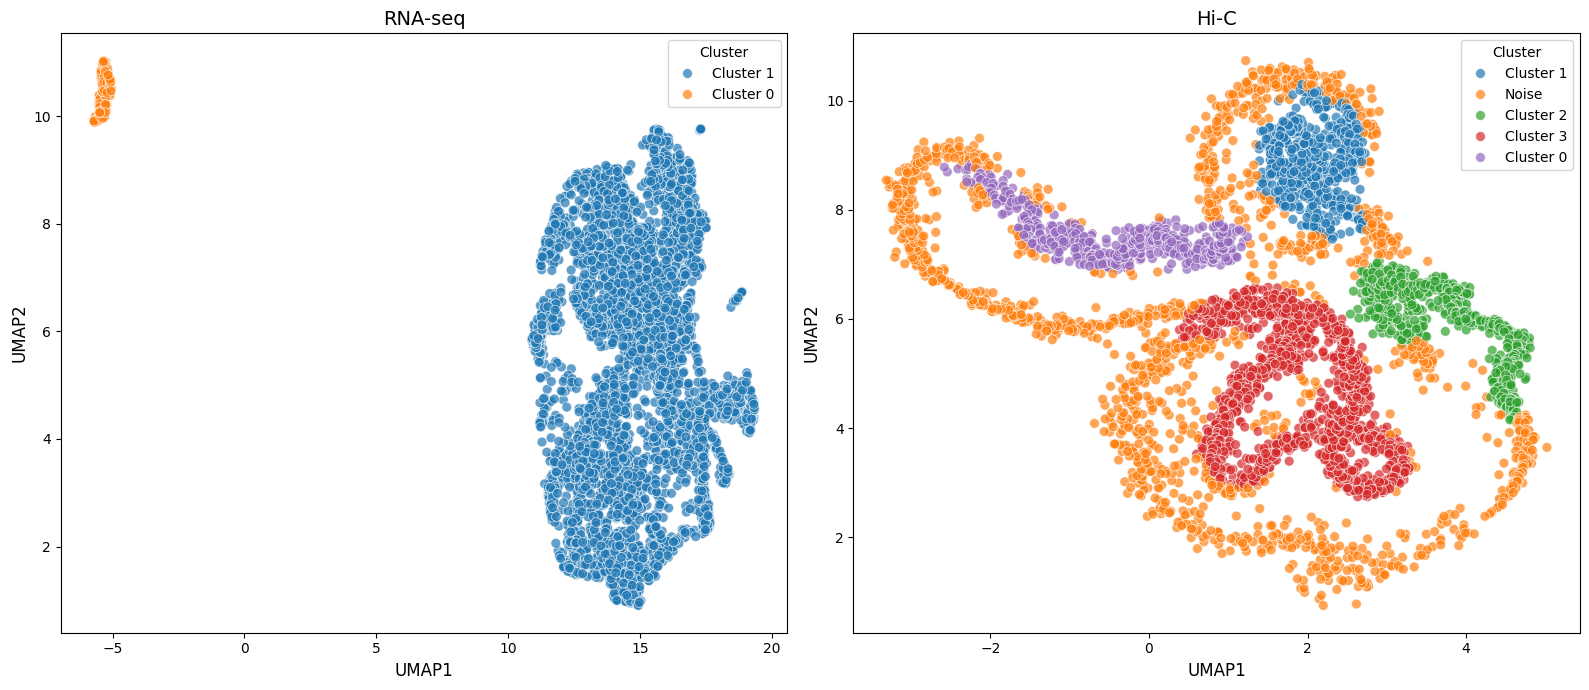

UMAP embeddings saved to:
  - ../results_scHiC/rna_umap_embedding.csv
  - ../results_scHiC/hic_umap_embedding.csv


In [39]:
# Visualize the UMAPs and save embeddings
results = visualize_aligned_datasets(
    aligned_rna, 
    aligned_hic,
    n_neighbors=15, 
    min_dist=0.1,
    output_dir="../results_scHiC"
)

In [ ]:
# Install local pygaudi
import sys
import subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "-e", "/path/pygaudi"])

In [40]:
import pandas as pd
import numpy as np
from pygaudi import gaudi

aligned_rna = pd.read_csv("../data/scHiC/aligned_rna_data.csv")
aligned_hic = pd.read_csv("../data/scHiC/aligned_hic_data.csv")

In [41]:
omics_list = [aligned_rna, aligned_hic]

# Run GAUDI with defaul parameters
result = gaudi(omics_list)

Aligning omics datasets...
Computing individual factorizations...
Concatenating factors...
Computing multi-omics factorization...
Computing multi-omics clustering...
Computing metagenes...
Multi-omics integration complete!


In [42]:
import pickle

with open('../results_scHiC/gaudi_object.pkl', 'wb') as f:
    pickle.dump({'result': result}, f)

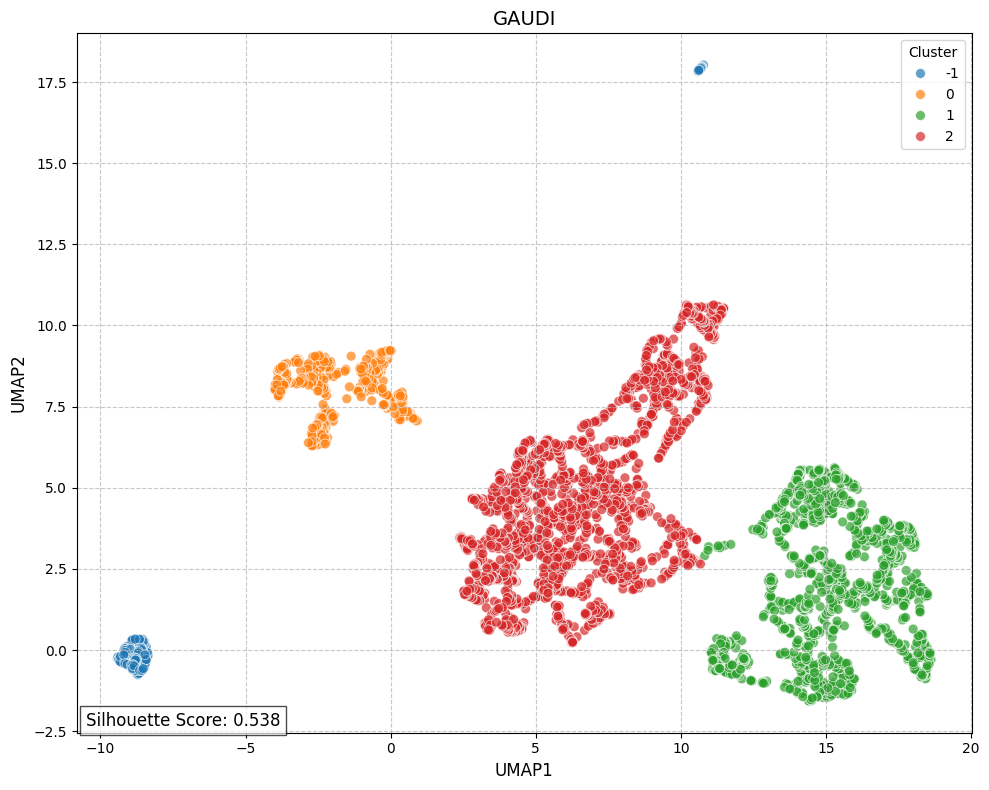

In [43]:
import pickle

with open('../results_scHiC/gaudi_object.pkl', 'rb') as f:
    loaded_objects = pickle.load(f)

result = loaded_objects['result']

from pygaudi.visualization import plot_clusters, plot_metagenes

plot_clusters(result, save_path='../results_scHiC/gaudi_integration.png')

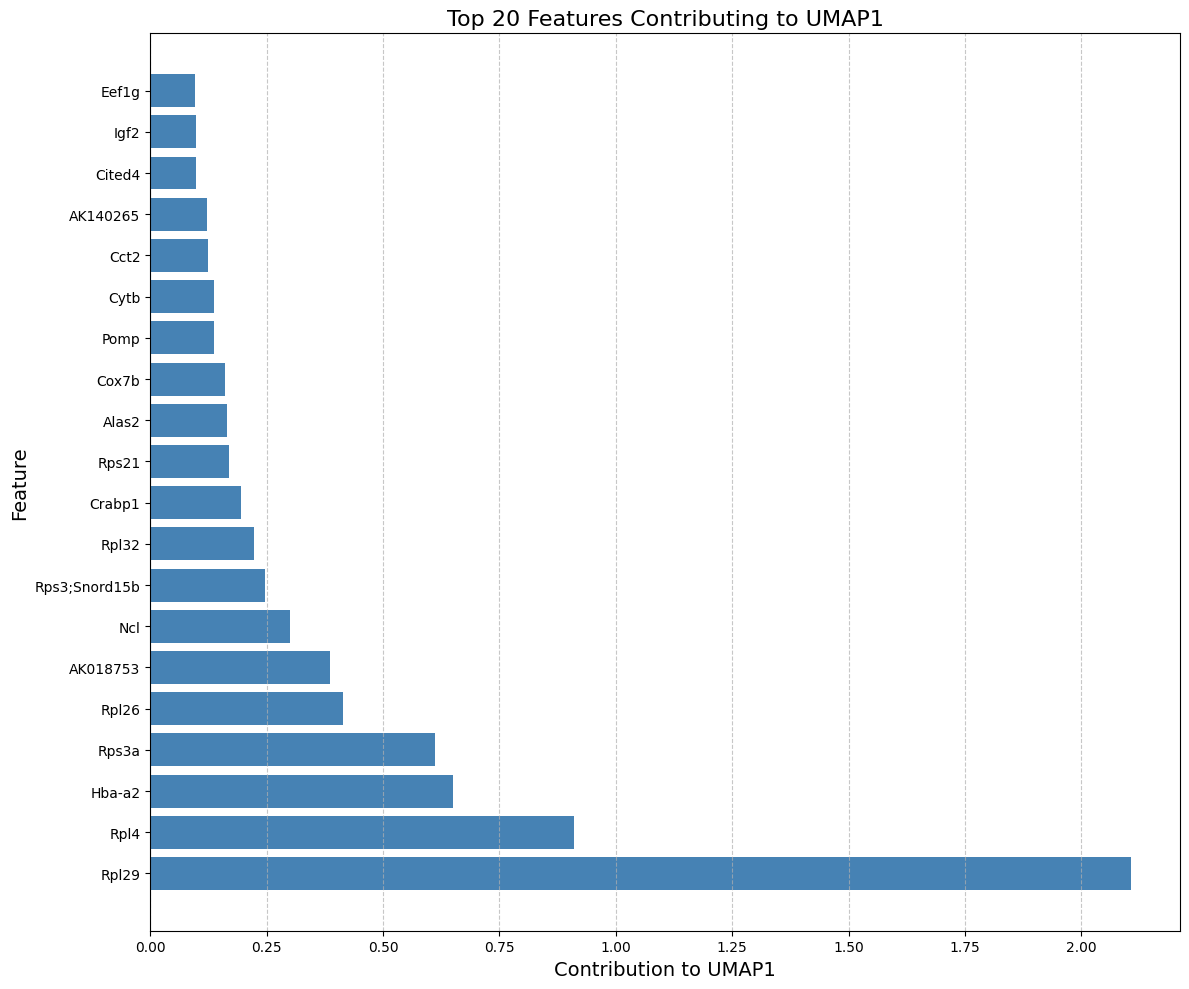

In [44]:
plot_metagenes(result, umap_dim=1)

In [45]:
import pandas as pd

sorted_data = pd.DataFrame(result.metagenes[0])
sorted_data = sorted_data.sort_values(by="contrib1", key=abs, ascending=False)
sorted_data = sorted_data[sorted_data['contrib1'] != 0]

sorted_data.index = [x.split(';')[-1] for x in sorted_data.index]

print(sorted_data)

               contrib1  contrib2
Rpl29          2.106604  0.000000
Rpl4           0.910160  1.006091
Hba-a2         0.650355  0.035514
Rps3a          0.611571  0.000000
Rpl26          0.414481  0.121340
...                 ...       ...
AF357374       0.001884  0.000000
AK087382       0.001728  0.000000
1810010H24Rik  0.001684  0.000000
0610007P22Rik  0.001444  0.000000
1700030K09Rik  0.001355  0.000000

[184 rows x 2 columns]


In [47]:
import gseapy as gp
import matplotlib.pyplot as plt
import numpy as np

databases = ['HDSigDB_Mouse_2021', 
             'KEGG_2019_Mouse', 
             'Mouse_Gene_Atlas', 
             'WikiPathways_2024_Mouse']

gene_list = sorted_data.index.tolist()

enrichr_results = gp.enrichr(gene_list=gene_list,
                             gene_sets=databases,
                             outdir='../results_scHiC/enrichr_results',
                             cutoff=0.1,
                             verbose=True)

fig, axes = plt.subplots(4, 1, figsize=(14, 30))

for i, database in enumerate(databases):
    db_results = enrichr_results.results[enrichr_results.results['Gene_set'] == database]
    
    if len(db_results) > 0:
        db_results.to_csv(f'../results_scHiC/{database}_results.csv')

        db_results = db_results.sort_values('Adjusted P-value').head(10)
        db_results['-log10(Adjusted P-value)'] = -np.log10(db_results['Adjusted P-value'])
        bars = axes[i].barh(y=db_results['Term'], width=db_results['-log10(Adjusted P-value)'])
        
        for j, bar in enumerate(bars):
            gene_count = len(db_results.iloc[j]['Genes'].split(';'))
            axes[i].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                        f'n={gene_count}', va='center')
        
        axes[i].set_title(f'{database} Enrichment')
        axes[i].set_xlabel('-log10(Adjusted P-value)')
        
        plt.figure(figsize=(12, 6))
        plt.barh(y=db_results['Term'], width=db_results['-log10(Adjusted P-value)'])
        plt.title(f'{database} Enrichment')
        plt.xlabel('-log10(Adjusted P-value)')
        plt.tight_layout()
        plt.savefig(f'../results_scHiC/{database}_enrichment.png')
        plt.close()
    else:
        axes[i].text(0.5, 0.5, f"No significant terms found for {database}",
                    ha='center', va='center')
        axes[i].set_title(f'{database} Enrichment')

plt.tight_layout()
plt.savefig('../results_scHiC/all_enrichment_results.png')
plt.close()

2025-03-26 17:16:25,543 [INFO] Run: HDSigDB_Mouse_2021 
2025-03-26 17:16:26,448 [INFO] Save enrichment results for HDSigDB_Mouse_2021 
2025-03-26 17:16:26,570 [INFO] Run: KEGG_2019_Mouse 
2025-03-26 17:16:27,323 [INFO] Save enrichment results for KEGG_2019_Mouse 
2025-03-26 17:16:27,445 [INFO] Run: Mouse_Gene_Atlas 
2025-03-26 17:16:28,112 [INFO] Save enrichment results for Mouse_Gene_Atlas 
2025-03-26 17:16:28,211 [INFO] Run: WikiPathways_2024_Mouse 
2025-03-26 17:16:28,834 [INFO] Save enrichment results for WikiPathways_2024_Mouse 
2025-03-26 17:16:28,961 [INFO] Done.
